In [195]:
import pandas as pd
import numpy as np
import seaborn as sns
import json
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [196]:
df_movie = pd.read_csv("https://raw.githubusercontent.com/rashida048/Datasets/master/movie_dataset.csv")

In [197]:
df_movie.describe()

,index,budget,id,popularity,revenue,runtime,vote_average,vote_count
count,4803.000000,4.803000e+03,4803.000000,4803.000000,4.803000e+03,4801.000000,4803.000000,4803.000000
mean,2401.000000,2.904504e+07,57165.484281,21.492301,8.226064e+07,106.875859,6.092172,690.217989
std,1386.651002,4.072239e+07,88694.614033,31.816650,1.628571e+08,22.611935,1.194612,1234.585891
min,0.000000,0.000000e+00,5.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,1200.500000,7.900000e+05,9014.500000,4.668070,0.000000e+00,94.000000,5.600000,54.000000
50%,2401.000000,1.500000e+07,14629.000000,12.921594,1.917000e+07,103.000000,6.200000,235.000000
75%,3601.500000,4.000000e+07,58610.500000,28.313505,9.291719e+07,118.000000,6.800000,737.000000
max,4802.000000,3.800000e+08,459488.000000,875.581305,2.787965e+09,338.000000,10.000000,13752.000000


# Looking at Null Values in the Dataset

In [213]:
df_movie.isna().sum()

index                             0
budget                            0
genres                           28
homepage                       3091
id                                0
keywords                        412
original_language                 0
original_title                    0
overview                          3
popularity                        0
production_companies              0
production_countries              0
release_date                      1
revenue                           0
runtime                           0
spoken_languages                  0
status                            0
tagline                         844
title                             0
vote_average                      0
vote_count                        0
cast                             43
crew                              0
director                         30
Drama                             0
Comedy                            0
Thriller                          0
Action                      

In [199]:
df_movie.eq(0).sum()

index                      1
budget                  1037
genres                     0
homepage                   0
id                         0
keywords                   0
original_language          0
original_title             0
overview                   0
popularity                 1
production_companies       0
production_countries       0
release_date               0
revenue                 1427
runtime                   35
spoken_languages           0
status                     0
tagline                    0
title                      0
vote_average              63
vote_count                62
cast                       0
crew                       0
director                   0
dtype: int64

# Cleaning Step 1: Treating Genre Column.     

A Single Movie is categorized into multiple genre; but they are kept in same column. 
Lets find all the categories of genre present in the dataset by parsing the genre column;
and make a separate column for each categories where we'll fill the columns with binary
encodings based on presence.
We Found 22 different categories in total.
(TV, Movies) and (Science, Fiction) are same category but parsed as different words by our initial 
pre-processing. So, we'll rework on them, and treat them as "TV Movie" and "Science Fiction" Categories.
Thus, altogether we'll have 20 different categories of genre, which we'll represent as different columns.

Examples of data in original 'genres' column

In [200]:
df_movie.genres.head()

0    Action Adventure Fantasy Science Fiction
1                    Adventure Fantasy Action
2                      Action Adventure Crime
3                 Action Crime Drama Thriller
4            Action Adventure Science Fiction
Name: genres, dtype: object

In [201]:
genre_names = []
for i in range(len(df_movie)):
    try:
        split_list = df_movie.genres[i].split()
        if "Science" in split_list and "Fiction" in split_list:
            split_list.remove("Science")
            split_list.remove("Fiction")
            split_list.append("Science Fiction")
        if "TV" in split_list and "Movie" in split_list:
            split_list.remove("TV")
            split_list.remove("Movie")
            split_list.append("TV Movie")
        genre_names.extend(split_list)
    except:
        pass
#         print("Record#: ",i, " is missing")

df_genre = pd.DataFrame(genre_names, columns=['Genre'])

<Axes: xlabel='Genre', ylabel='No. of Movies'>

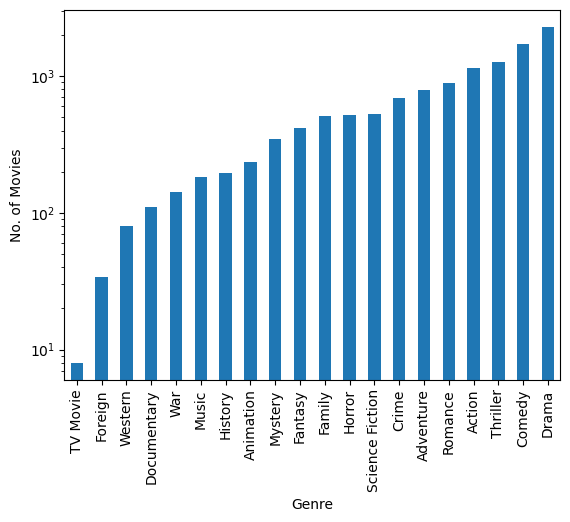

In [202]:
df_genre.Genre.value_counts().sort_values().plot(kind = 'bar',logy = True, xlabel="Genre",ylabel = "No. of Movies")

In [203]:
new_columns = []
for i in range (len(df_genre.Genre.value_counts().keys())):
    new_columns.append(df_genre.Genre.value_counts().keys()[i])

In [204]:
for item in new_columns:
    binary_list = []
    for i in range(len(df_movie)):
        try:
            if item in df_movie.genres[i]:
                binary_list.append(1)
            else:
                binary_list.append(0)
                
        except:
            binary_list.append(0)
    df_movie[item] = binary_list

# Cleaning Step 2: Treating Production_Companies Column.

The Feature is a json that mentions all the production companies involved. These are text features and we'll convert it into a new
feature that demonstrates no. of production companies involved in making the movie.
Examples of data in this column:

[{'name': 'Ingenious Film Partners', 'id': 289}, {'name': 'Twentieth Century Fox Film Corporation', 'id': 306}, {'name': 'Dune Entertainment', 'id': 444}, {'name': 'Lightstorm Entertainment', 'id': 574}]

[{'name': 'Walt Disney Pictures', 'id': 2}, {'name': 'Jerry Bruckheimer Films', 'id': 130}, {'name': 'Second Mate Productions', 'id': 19936}]

[{'name': 'Columbia Pictures', 'id': 5}, {'name': 'Danjaq', 'id': 10761}, {'name': 'B24', 'id': 69434}]

In [205]:
num_prod_comp = []
for i in range(len(df_movie)):
    num_prod_comp.append(len(json.loads(df_movie.production_companies[i])))
df_movie["num_of_production_companies"] = num_prod_comp   

In [206]:
type(df_movie.num_of_production_companies.value_counts().sort_values())

pandas.core.series.Series

<Axes: xlabel='No. of Production Companies involved', ylabel='no. of Movies'>

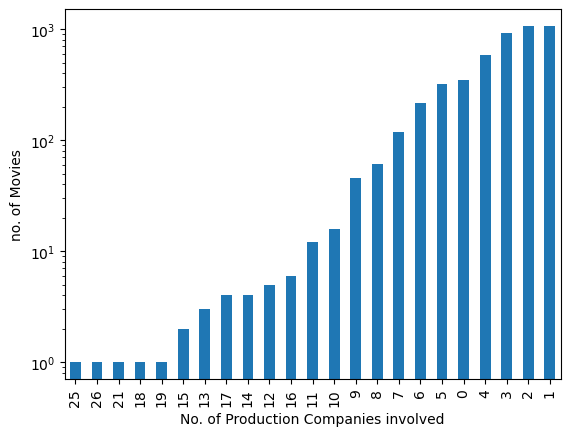

In [207]:
df_movie.num_of_production_companies.value_counts().sort_values().plot(kind = 'bar', logy = True,
                                                                       xlabel = "No. of Production Companies involved",
                                                                      ylabel = "no. of Movies")

# Cleaning Step 3: Filling Missing Values(Replacing Null) in Runtime Column

two records for runtime columns have missing values, which we will fill by looking up imdb data.

In [208]:
df_movie[df_movie['runtime'].isnull()]

,index,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew,director,Drama,Comedy,Thriller,Action,Romance,Adventure,Crime,Science Fiction,Horror,Family,Fantasy,Mystery,Animation,History,Music,War,Documentary,Western,Foreign,TV Movie,num_of_production_companies
2656,2656,15000000,Drama,NaN,370980,pope biography,it,Chiamatemi Francesco - Il Papa della gente,NaN,0.738646,"[{""name"": ""Taodue Film"", ""id"": 45724}]","[{""iso_3166_1"": ""IT"", ""name"": ""Italy""}]",2015-12-03,0,NaN,"[{""iso_639_1"": ""es"", ""name"": ""Espa\u00f1ol""}]",Released,NaN,Chiamatemi Francesco - Il Papa della gente,7.3,12,Rodrigo de la Serna Sergio Hern\u00e1ndez \u00...,"[{'name': 'Daniele Luchetti', 'gender': 0, 'de...",Daniele Luchetti,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4140,4140,2,Documentary,NaN,459488,music actors legendary perfomer classic hollyw...,en,"To Be Frank, Sinatra at 100",NaN,0.050625,"[{""name"": ""Eyeline Entertainment"", ""id"": 60343}]","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""}]",2015-12-12,0,NaN,[],Released,NaN,"To Be Frank, Sinatra at 100",0.0,0,Tony Oppedisano,"[{'name': 'Simon Napier-Bell', 'gender': 0, 'd...",Simon Napier-Bell,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1


In [209]:
df_movie['runtime'].fillna({2656: '113.0', 4140: '81.0'}, inplace=True)

In [210]:
df_movie[df_movie['runtime'].isnull()]

,index,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew,director,Drama,Comedy,Thriller,Action,Romance,Adventure,Crime,Science Fiction,Horror,Family,Fantasy,Mystery,Animation,History,Music,War,Documentary,Western,Foreign,TV Movie,num_of_production_companies


In [211]:
df_movie.head()

,index,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew,director,Drama,Comedy,Thriller,Action,Romance,Adventure,Crime,Science Fiction,Horror,Family,Fantasy,Mystery,Animation,History,Music,War,Documentary,Western,Foreign,TV Movie,num_of_production_companies
0,0,237000000,Action Adventure Fantasy Science Fiction,http://www.avatarmovie.com/,19995,culture clash future space war space colony so...,en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Sam Worthington Zoe Saldana Sigourney Weaver S...,"[{'name': 'Stephen E. Rivkin', 'gender': 0, 'd...",James Cameron,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,4
1,1,300000000,Adventure Fantasy Action,http://disney.go.com/disneypictures/pirates/,285,ocean drug abuse exotic island east india trad...,en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Johnny Depp Orlando Bloom Keira Knightley Stel...,"[{'name': 'Dariusz Wolski', 'gender': 2, 'depa...",Gore Verbinski,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,3
2,2,245000000,Action Adventure Crime,http://www.sonypictures.com/movies/spectre/,206647,spy based on novel secret agent sequel mi6,en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,Daniel Craig Christoph Waltz L\u00e9a Seydoux ...,"[{'name': 'Thomas Newman', 'gender': 2, 'depar...",Sam Mendes,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,3
3,3,250000000,Action Crime Drama Thriller,http://www.thedarkknightrises.com/,49026,dc comics crime fighter terrorist secret ident...,en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,Christian Bale Michael Caine Gary Oldman Anne ...,"[{'name': 'Hans Zimmer', 'gender': 2, 'departm...",Christopher Nolan,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,4
4,4,260000000,Action Adventure Science Fiction,http://movies.disney.com/john-carter,49529,based on novel mars medallion space travel pri...,en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,Taylor Kitsch Lynn Collins Samantha Morton Wil...,"[{'name': 'Andrew Stanton', 'gender': 2, 'depa...",Andrew Stanton,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1


In [212]:
df_movie.to_csv('data_movies_v2.csv',index=False)

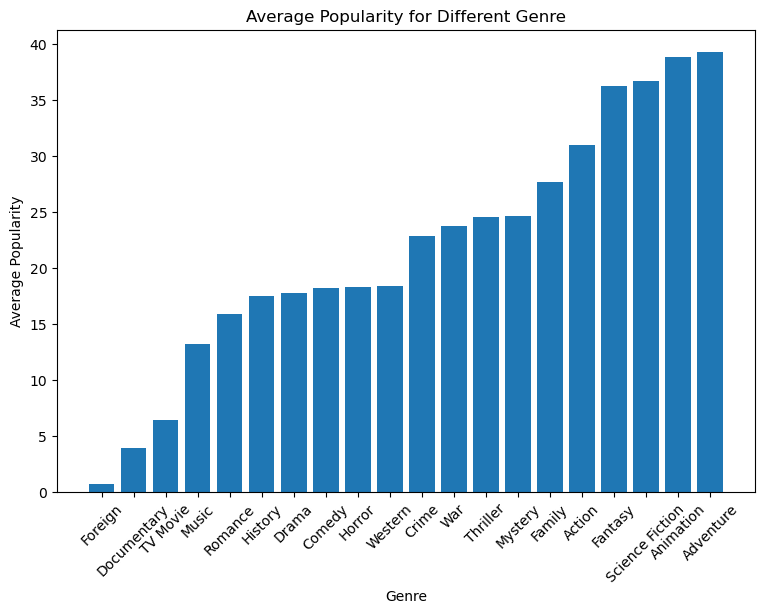

In [153]:
columns_to_plot = df_movie.columns.values.tolist()[24:44]

#a dictionary to store average popularities for each genre
average_popularities = {}

#average popularity for each genre
for column in columns_to_plot:
    average_popularity = df_movie[df_movie[column] == 1]['popularity'].mean()
    average_popularities[column] = average_popularity
    
sorted_popularities = dict(sorted(average_popularities.items(), key=lambda item: item[1]))

plt.figure(figsize=(9, 6))
plt.bar(sorted_popularities.keys(), sorted_popularities.values())
plt.xlabel('Genre')
plt.ylabel('Average Popularity')
plt.title('Average Popularity for Different Genre')
plt.xticks(rotation=45)
plt.show()


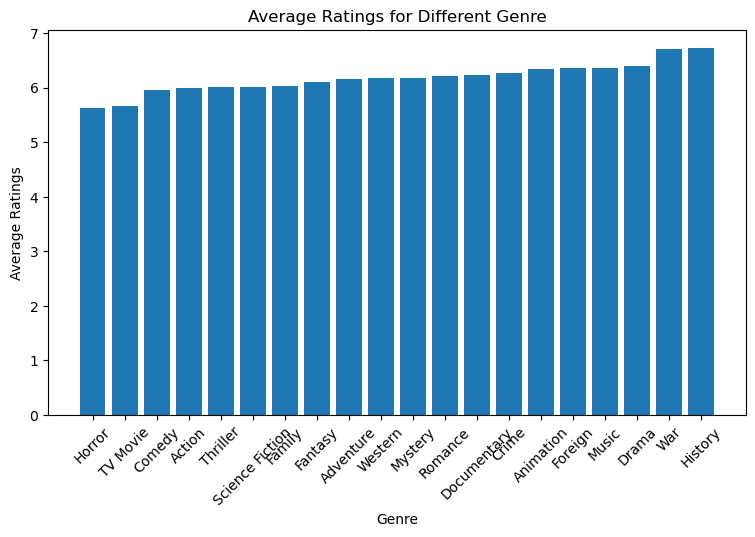

In [154]:
average_ratings = {}

for column in columns_to_plot:
    average_rating = df_movie[df_movie[column] == 1]['vote_average'].mean()
    average_ratings[column] = average_rating
    
sorted_ratings = dict(sorted(average_ratings.items(), key=lambda item: item[1]))

plt.figure(figsize=(9, 5))
plt.bar(sorted_ratings.keys(), sorted_ratings.values())
plt.xlabel('Genre')
plt.ylabel('Average Ratings')
plt.title('Average Ratings for Different Genre')
plt.xticks(rotation=45)
plt.show()


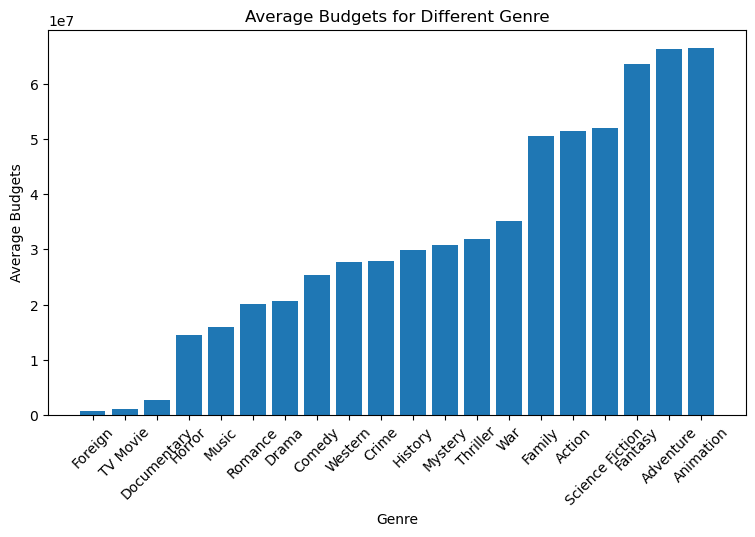

In [155]:
average_budgets = {}

for column in columns_to_plot:
    average_budget = df_movie[df_movie[column] == 1]['budget'].mean()
    average_budgets[column] = average_budget
    
sorted_budgets = dict(sorted(average_budgets.items(), key=lambda item: item[1]))

plt.figure(figsize=(9, 5))
plt.bar(sorted_budgets.keys(), sorted_budgets.values())
plt.xlabel('Genre')
plt.ylabel('Average Budgets')
plt.title('Average Budgets for Different Genre')
plt.xticks(rotation=45)
plt.show()


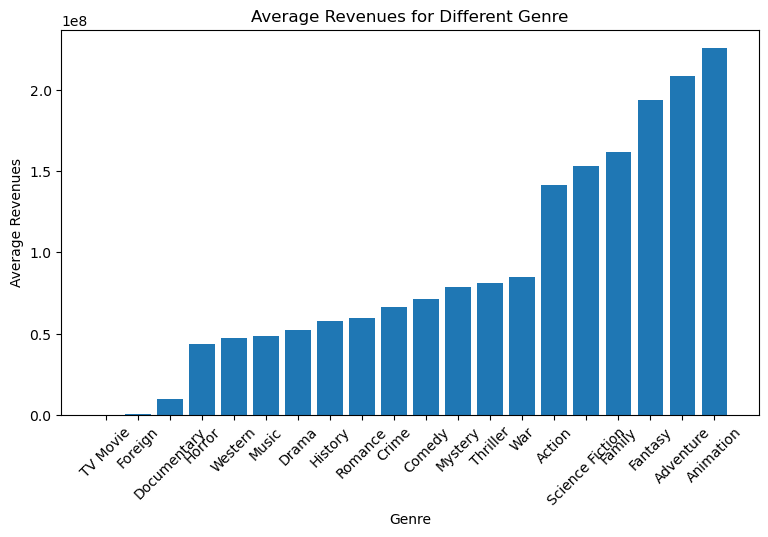

In [156]:
average_revenues = {}

for column in columns_to_plot:
    average_revenue = df_movie[df_movie[column] == 1]['revenue'].mean()
    average_revenues[column] = average_revenue
    
sorted_revenues = dict(sorted(average_revenues.items(), key=lambda item: item[1]))

plt.figure(figsize=(9, 5))
plt.bar(sorted_revenues.keys(), sorted_revenues.values())
plt.xlabel('Genre')
plt.ylabel('Average Revenues')
plt.title('Average Revenues for Different Genre')
plt.xticks(rotation=45)
plt.show()

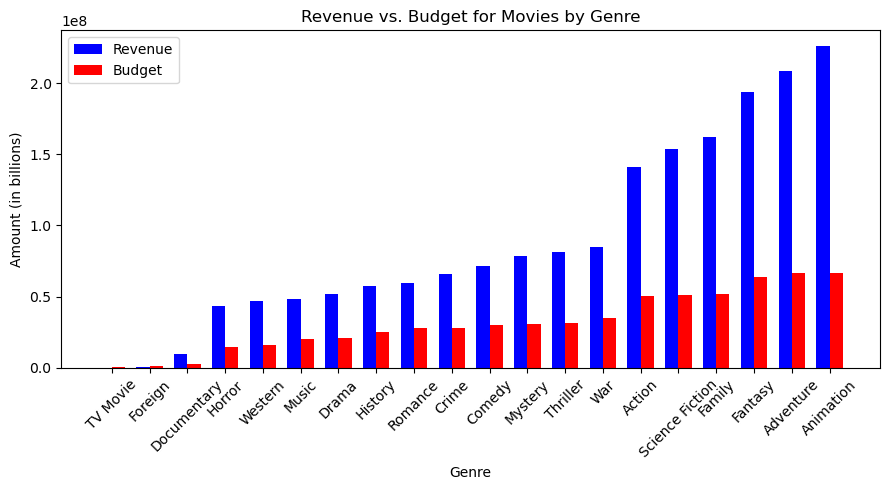

In [157]:
genres = list(sorted_revenues.keys())
index = np.arange(len(genres))

bar_width = 0.35

#grouped bar chart
plt.figure(figsize=(9, 5))
plt.bar(index - bar_width/2, list(sorted_revenues.values()), bar_width, label='Revenue', color='b', align='center')
plt.bar(index + bar_width/2, list(sorted_budgets.values()), bar_width, label='Budget', color='r', align='center')

plt.xlabel('Genre')
plt.ylabel('Amount (in billions)')
plt.title('Revenue vs. Budget for Movies by Genre')
plt.xticks(index, genres, rotation=45)
plt.legend()

plt.tight_layout()
plt.show()


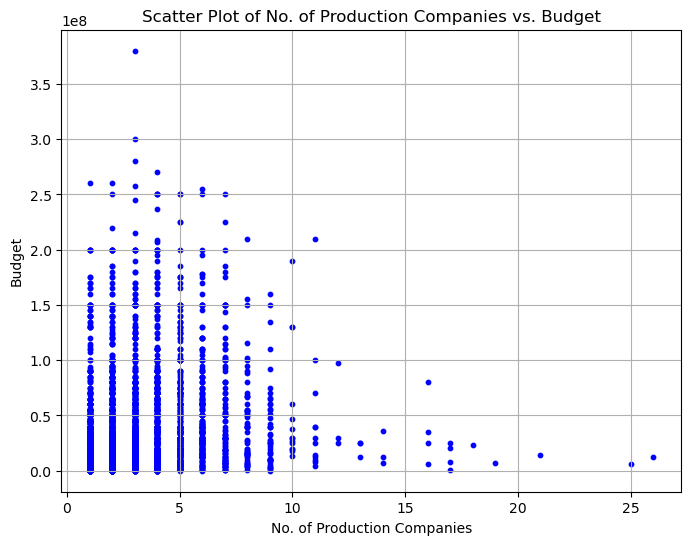

In [158]:
# scatter plot
df_for_plot = df_movie[(df_movie[['num_of_production_companies','budget']] != 0).all(axis=1)]
plt.figure(figsize=(8, 6))
plt.scatter(df_for_plot['num_of_production_companies'], df_for_plot['budget'], color='b', alpha=0.99, s = 10)
plt.xlabel('No. of Production Companies')
plt.ylabel('Budget')
plt.title('Scatter Plot of No. of Production Companies vs. Budget')
plt.grid(True)
plt.show()

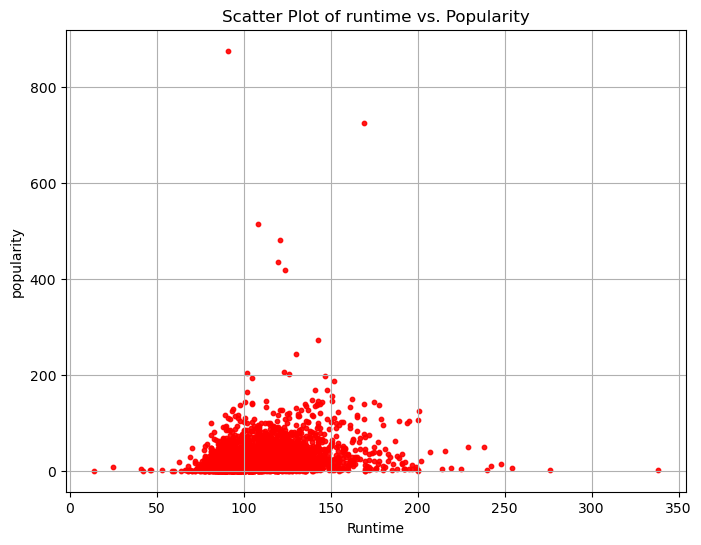

In [159]:
# scatter plot
df_for_plot = df_movie[(df_movie[['runtime','popularity']] != 0).all(axis=1)]
plt.figure(figsize=(8, 6))
plt.scatter(df_for_plot['runtime'], df_for_plot['popularity'], color='r', alpha=0.9, s = 10)
plt.xlabel('Runtime')
plt.ylabel('popularity')
plt.title('Scatter Plot of runtime vs. Popularity')
plt.grid(True)
plt.show()

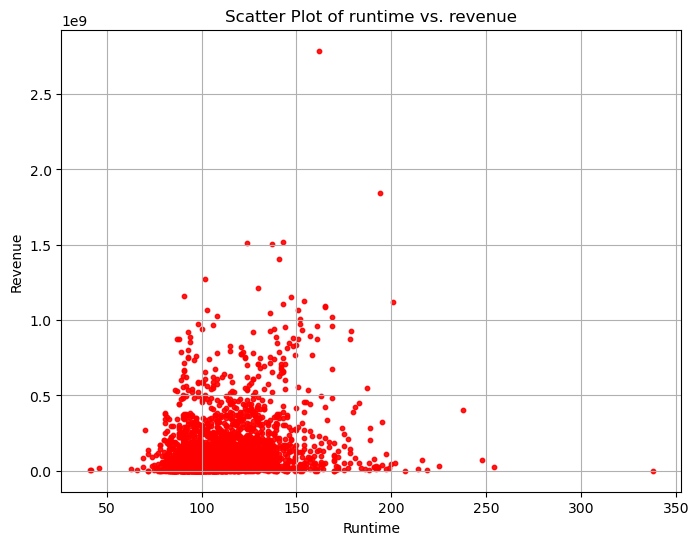

In [160]:
# scatter plot
df_for_plot = df_movie[(df_movie[['runtime','revenue']] != 0).all(axis=1)]
plt.figure(figsize=(8, 6))
plt.scatter(df_for_plot['runtime'], df_for_plot['revenue'], color='r', alpha=0.9, s = 10)
plt.xlabel('Runtime')
plt.ylabel('Revenue')
plt.title('Scatter Plot of runtime vs. revenue')
plt.grid(True)
plt.show()

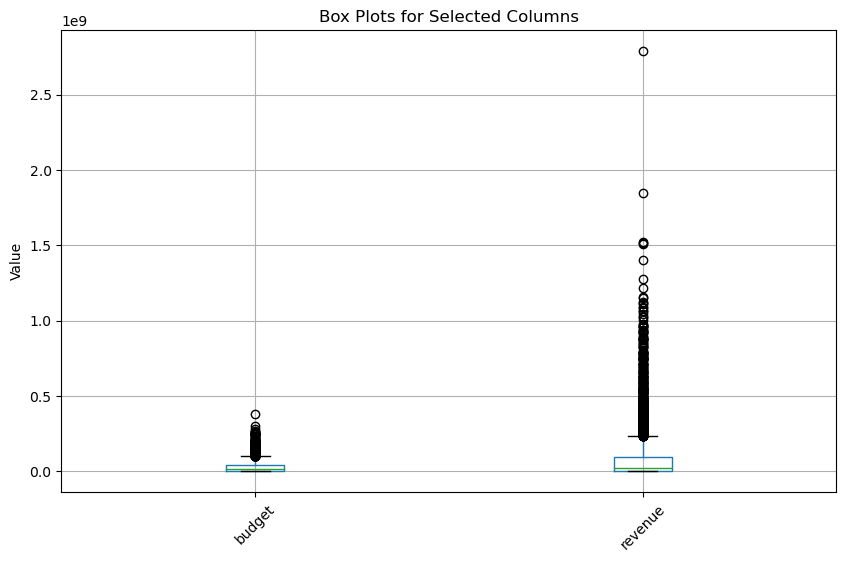

In [161]:
# Create box plots for 'Column1' and 'Column3'
selected_columns = ['budget', 'revenue']

plt.figure(figsize=(10, 6))
df_movie[selected_columns].boxplot()
plt.title('Box Plots for Selected Columns')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.show()


In [162]:
# boxplots for ['runtime','vote_average','popularity']

In [163]:
df_for_heatmap = df_movie[(df_movie[['budget','popularity','revenue', 'runtime','vote_average', 'vote_count']] != 0).all(axis=1)]

In [164]:
df_for_heatmap = df_for_heatmap.loc[:, ['budget','popularity','revenue', 'runtime','vote_average', 'vote_count','Drama','Comedy', 'Thriller', 'Action', 'Romance', 'Adventure', 'Crime','Science Fiction', 'Horror', 'Family', 'Fantasy', 'Mystery','Animation', 'History', 'Music', 'War', 'Documentary', 'Western','Foreign', 'TV Movie', 'num_of_production_companies']]

<Axes: >

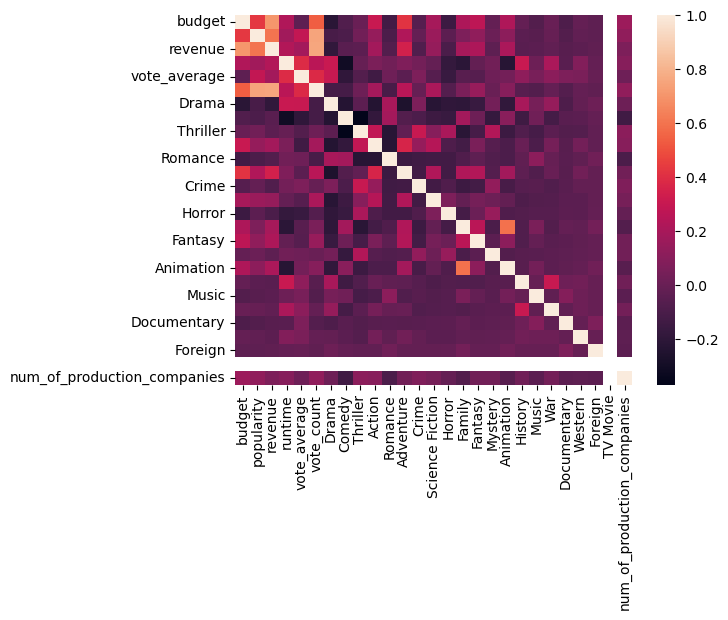

In [165]:
sns.heatmap(df_for_heatmap.corr()) 
  
# # displaying heatmap 
# mp.show()

In [166]:
df_movie.to_csv('data_movies_v2.csv',index=False)

In [ ]:
Problem Statement: Prediction of revenue/popularity of a movie